# Ocean cleaning

Since the begining of humanity ...

In [1]:
import cudaq
from cudaq import spin
import itertools
import json
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_histogram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_optimization.applications import Maxcut, Tsp
from typing import List
from utils.tsp import brute_force_tsp
from utils.graph import generate_point_graph_with_weights, draw_graph

cudaq.set_target('qpp-cpu') # Comment this to run on GPU

np.random.seed(42)
cudaq.set_random_seed(42)

## Problem definition

In [2]:
number_of_garbage = 3

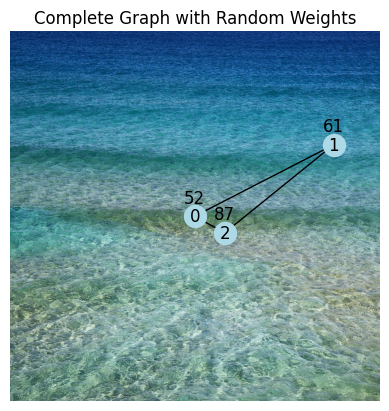

In [3]:
img = plt.imread("img/ocean.jpg")
fig, ax = plt.subplots()
ax.imshow(img, extent=[-0.1, 1.1, -0.1, 1.1])

# Drawing the graph
garbage_graph = generate_point_graph_with_weights(number_of_garbage)
positions = nx.get_node_attributes(garbage_graph, 'pos')
nx.draw(garbage_graph, positions, with_labels=True, node_color='lightblue', edge_color='black', node_size=250) # drawing nodes
label_pos = {node: (position[0], position[1] + 0.06) for node, position in positions.items()}  # Adjust 0.1 as needed
labels = {node: garbage_graph.nodes[node]['weight'] for node in garbage_graph.nodes()}
nx.draw_networkx_labels(garbage_graph, label_pos, labels=labels, font_size=12, font_color='black')

# Show the graph
plt.title('Complete Graph with Random Weights')
plt.show()


## Clustering

The problem is NP-Hard and would require a lot of computational power to solve it. We can use clustering to divide the problem into smaller problems and allow some current quantum computer or simulator.

In this part, we are clustering the VRP problem so that it can be divided into multiple TSP problem.

## TSP & QUBO matrix

### QUBO to Maxcut

### TSP Definition

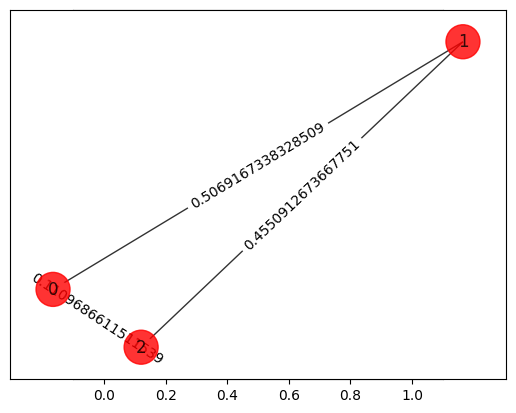

In [4]:
adj_matrix = nx.to_numpy_array(garbage_graph)
#print("distance\n", adj_matrix)

colors = ["r" for node in garbage_graph.nodes]
pos = [garbage_graph.nodes[node]["pos"] for node in garbage_graph.nodes]
draw_graph(garbage_graph, colors, pos)

### TSP Classical

Best order from brute force = (0, 2, 1) with total distance = 1.0729766623507797


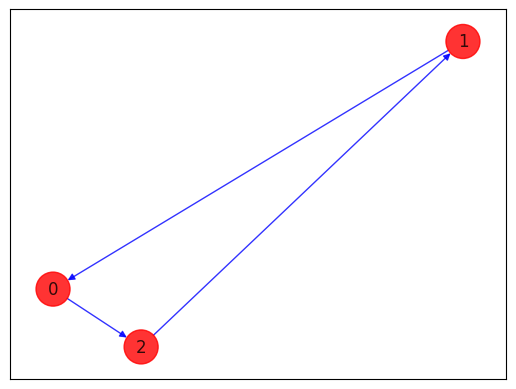

In [5]:
best_distance, best_order = brute_force_tsp(adj_matrix, number_of_garbage)
print(
    "Best order from brute force = "
    + str(best_order)
    + " with total distance = "
    + str(best_distance)
)


def draw_tsp_solution(G, order, colors, pos):
    G2 = nx.DiGraph()
    G2.add_nodes_from(G)
    n = len(order)
    for i in range(n):
        j = (i + 1) % n
        G2.add_edge(order[i], order[j], weight=G[order[i]][order[j]]["weight"])
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(
        G2, node_color=colors, edge_color="b", node_size=600, alpha=0.8, ax=default_axes, pos=pos
    )
    edge_labels = nx.get_edge_attributes(G2, "weight")


draw_tsp_solution(garbage_graph, best_order, colors, pos)


### TSP Nvidia

In [6]:
tsp = Tsp(garbage_graph)

qp = tsp.to_quadratic_program()

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()

In [7]:
coeffs = qubitOp.coeffs

hamiltonian = 0

for i in range(len(qubitOp.paulis)):
    only_one = True
    # find position of first Z
    #print(str(qubitOp.paulis[i]))
    pauli_string = str(qubitOp[i].to_list()[0][0])
    x = pauli_string.index("Z")
    y = x
    # check if their is another Z
    if pauli_string.count("Z") > 1:
        only_one = False
        y = pauli_string.index("Z", x + 1)

    if only_one:
        hamiltonian += coeffs[i] * spin.z(y)
    else:
        hamiltonian += coeffs[i] * spin.z(x) * spin.z(y)


In [8]:
# Problem parameters.
qubit_count: int = number_of_garbage ** 2
layer_count: int = 2
parameter_count: int = 2 * layer_count


@cudaq.kernel
def kernel_qaoa(qubit_count: int, layer_count: int, thetas: List[float]):
    """QAOA ansatz for Max-Cut"""
    qvector = cudaq.qvector(qubit_count)

    # Create superposition
    h(qvector)

    # Loop over the layers
    for layer in range(layer_count):
        # Loop over the qubits
        # Problem unitary
        for qubit in range(qubit_count):
            x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])
            rz(2.0 * thetas[layer], qvector[(qubit + 1) % qubit_count])
            x.ctrl(qvector[qubit], qvector[(qubit + 1) % qubit_count])

        # Mixer unitary
        for qubit in range(qubit_count):
            rx(2.0 * thetas[layer + layer_count], qvector[qubit])


# Specify the optimizer and its initial parameters. Make it repeatable.
optimizer = cudaq.optimizers.COBYLA()
optimizer.initial_parameters = np.random.uniform(-np.pi / 8.0, np.pi / 8.0,
                                                 parameter_count)
print("Initial parameters = ", optimizer.initial_parameters)


# Define the objective, return `<state(params) | H | state(params)>`
def objective(parameters):
    return cudaq.observe(kernel_qaoa, hamiltonian, qubit_count, layer_count,
                         parameters).expectation()


# Optimize!
optimal_expectation, optimal_parameters = optimizer.optimize(
    dimensions=parameter_count, function=objective)

# Print the optimized value and its parameters
print("Optimal value = ", optimal_expectation)
print("Optimal parameters = ", optimal_parameters)

# Sample the circuit using the optimized parameters
counts = cudaq.sample(kernel_qaoa, qubit_count, layer_count, optimal_parameters)

Initial parameters =  [-0.3470803193783306, 0.2875940723715904, 0.07941554451502764, 0.16341982045438685]
Optimal value =  -16.44230544147448
Optimal parameters =  [2.201540082783372, 1.1768945043175343, 1.9188820480817006, 0.8281196117811718]


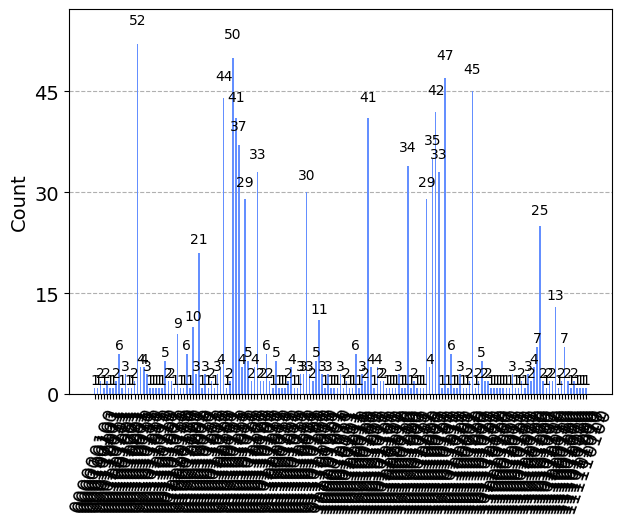

In [9]:
results = {}
for i, key in counts.items():
    results[i] = key

plot_histogram(results)

In [13]:
# Find the maximum frequency
max_frequency = max(results.values())

# Find the top 5 most frequent binary strings
sorted_results = sorted(results.items(), key=lambda item: item[1], reverse=True)
top_five = sorted_results[:5]

# Print the results
print("Top 5 most frequent binary strings:")
for binary_string, frequency in top_five:
    print(f"Binary string: {binary_string}, Frequency: {frequency}")

Top 5 most frequent binary strings:
Binary string: 001010101, Frequency: 52
Binary string: 010101001, Frequency: 50
Binary string: 101011010, Frequency: 47
Binary string: 101101010, Frequency: 45
Binary string: 010100101, Frequency: 44
